# Spectral solar irradiance

SIM SORCE: [source](ftp://acdisc.gsfc.nasa.gov/data/s4pa/SORCE_Level3/SOR3XPSD.010/sorce_xps_L3_c24h_v10_20030210_20110502.txt)


### Plot mean solar spectrum on one day:

In [110]:
%matplotlib inline

from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import h5py

date = 0

f = h5py.File('sorce_sim.hdf5', 'r')
spectra = f['spectra']
mean_wavelength = spectra.attrs['wavelengths']
sorce_jds = spectra.attrs['jd']

#plt.plot(mean_wavelength, np.std(spectra[..., 0], axis=0))
##plt.ylim([0,0.01])

        

### Daily sunspot number

[WDC-SILSO, Royal Observatory of Belgium, Brussels](http://www.sidc.be/silso/datafiles).

[Specific table source](http://www.sidc.be/silso/DATA/SN_d_tot_V2.0.txt)

> Daily total sunspot number derived by the formula: R= Ns + 10 * Ng, with Ns the number of spots and Ng the number of groups counted over the entire solar disk. ...

> Column 5: Daily total sunspot number. A value of -1 indicates that no number is available for that day (missing value).

> Column 6: 
Daily standard deviation of the input sunspot numbers from individual stations.

> Column 7: 
Number of observations used to compute the daily value.

> Column 8: Definitive/provisional indicator. A blank indicates that the value is definitive. A '*' symbol indicates that the value is still provisional and is subject to a possible revision (Usually the last 3 to 6 months)



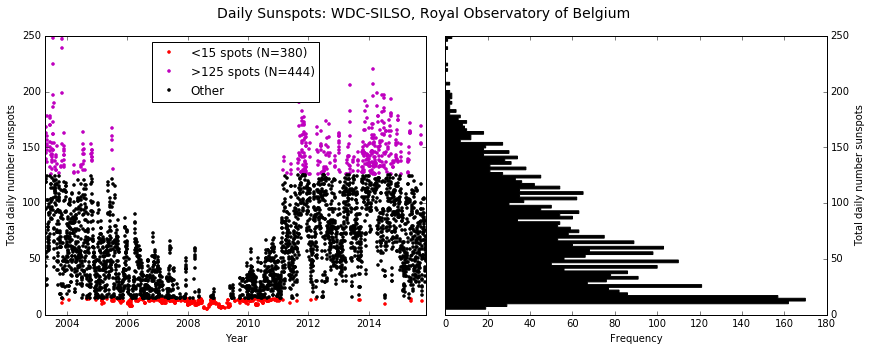

In [151]:
daily_sunspots_record = np.genfromtxt('SN_d_tot_V2.0.txt', 
                                      delimiter=(4, 3, 3, 9, 5, 7, 5))

dates = daily_sunspots_record[-10000:, 3]
n_spots = daily_sunspots_record[-10000:, 4]
# Mask out days with `-1` => missing data, 
dates = dates[n_spots > 0]
n_spots = n_spots[n_spots > 0]

# mask days before the first date in the SORCE data
import datetime
from astropy.time import Time
import astropy.units as u
time0 = Time([datetime.datetime(int(d // 1), 1, 1) for d in dates])
time1 = (dates - (dates // 1))*u.year
dates_ap = time0 + time1

n_spots = n_spots[dates_ap.jd > sorce_jds.min()]
dates_ap = dates_ap[dates_ap.jd > sorce_jds.min()]

spot_upper_limit = 15
spot_lower_limit = 125
n_bins = 100

indices_few_spots = (0 < n_spots) & (n_spots < spot_upper_limit)
indices_many_spots = (spot_lower_limit < n_spots)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot_date(dates_ap[indices_few_spots].plot_date, 
                n_spots[indices_few_spots], 'r.', 
                label="<{0} spots (N={1})"
                      .format(spot_upper_limit, np.count_nonzero(indices_few_spots)))

ax[0].plot_date(dates_ap[indices_many_spots].plot_date, 
                n_spots[indices_many_spots], 'm.', 
                label=">{0} spots (N={1})"
                      .format(spot_lower_limit, np.count_nonzero(indices_many_spots)))

ax[0].plot_date(dates_ap[~indices_few_spots & ~indices_many_spots].plot_date,
                n_spots[~indices_few_spots & ~indices_many_spots], 
                'k.', label="Other".format(spot_upper_limit))

ax[0].set(xlabel='Year', ylabel='Total daily number sunspots')
ax[0].legend(numpoints=1, loc='upper center')


ax[1].hist(n_spots[n_spots > 0], n_bins, orientation='horizontal',
           histtype='stepfilled', color='k')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].set(xlabel='Frequency', ylabel='Total daily number sunspots')
fig.subplots_adjust(wspace=0.05)
fig.suptitle('Daily Sunspots: WDC-SILSO, Royal Observatory of Belgium', fontsize=14)
plt.show()

For days with few spots: get spectrum from SORCE/SIM

In [180]:
brussels_few_spots_jds = dates_ap[indices_few_spots].jd
nearest_few_spots_jd = np.unique(sorted([np.argmin(np.abs(brussels_jd - sorce_jds)) 
                                         for brussels_jd in brussels_few_spots_jds]))
brussels_many_spots_jds = dates_ap[indices_many_spots].jd
nearest_many_spots_jd = np.unique(sorted([np.argmin(np.abs(brussels_jd - sorce_jds)) 
                                          for brussels_jd in brussels_many_spots_jds]))


sorce_mean_few_spots = np.mean(spectra[nearest_sorce_jd, :, 0], axis=0)
sorce_mean_many_spots = np.mean(spectra[nearest_many_spots_jd, :, 0], axis=0)

sorce_std_few_spots = np.std(spectra[nearest_sorce_jd, :, 0], axis=0)
sorce_std_many_spots = np.std(spectra[nearest_many_spots_jd, :, 0], axis=0)

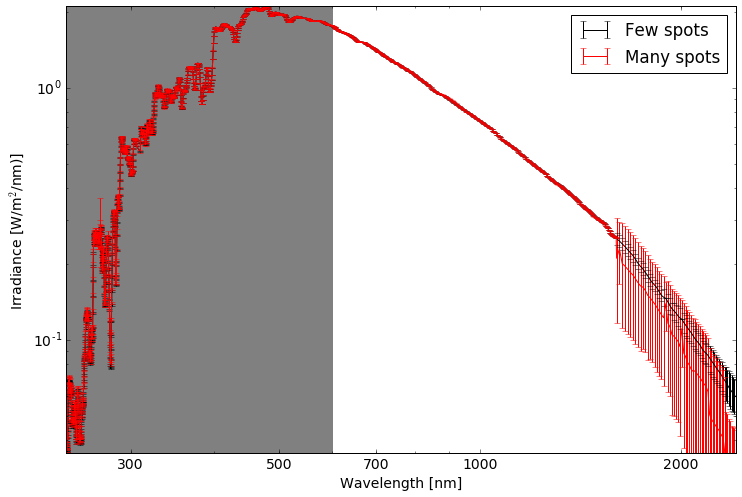

In [181]:
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(12, 8))
#ax.plot(mean_wavelength, sorce_mean_few_spots, 'k', label='Few spots')
#ax.plot(mean_wavelength, sorce_mean_many_spots, 'r', label='Many spots')
ax.errorbar(mean_wavelength, sorce_mean_few_spots, 
            sorce_std_few_spots, color='k', label='Few spots')
ax.errorbar(mean_wavelength, sorce_mean_many_spots, 
            sorce_std_many_spots, color='r', label='Many spots')
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.fill_between([0, 600], sorce_mean_few_spots.min(), 
                sorce_mean_few_spots.max(), color='gray')
ax.set(xlim=(mean_wavelength.min(), mean_wavelength.max()),
       ylim=(sorce_mean_few_spots.min(), sorce_mean_few_spots.max()), 
       xlabel='Wavelength [nm]', ylabel='Irradiance [W/m$^2$/nm)]')

xticks=[300, 500, 700, 1000, 2000]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks);

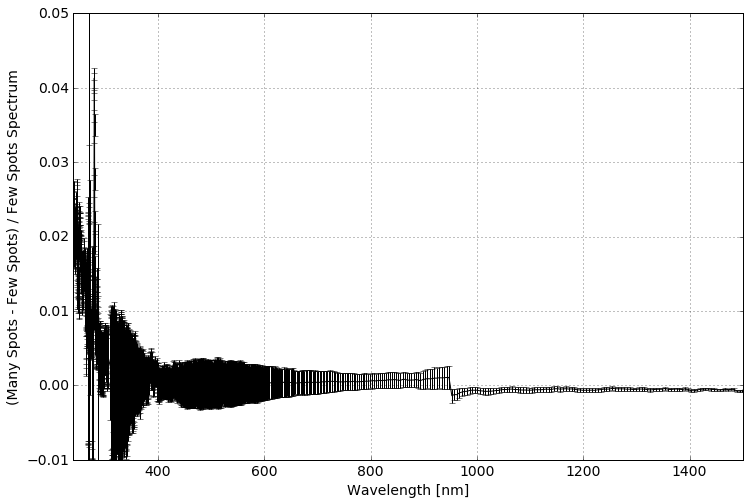

In [228]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(mean_wavelength, 
            (sorce_mean_many_spots - sorce_mean_few_spots)/sorce_mean_few_spots, 
            np.sqrt(sorce_std_few_spots**2 + sorce_std_many_spots**2),
            color='k', label='Few spots')

ax.set(xlim=(mean_wavelength.min(), 1500),#400),
       ylim=(-0.01, 0.05),
       xlabel='Wavelength [nm]', ylabel='(Many Spots - Few Spots) / Few Spots Spectrum')

#xticks=[300, 500]
ax.grid()
#ax.set_xticks(xticks)
#ax.set_xticklabels(xticks);

The Mg II H & K doublet at 280 nm has been used as a chromospheric activity indicator extensively in the literature: 

* [The Mg 280-nm doublet as a monitor of changes in solar ultraviolet irradiance](http://adsabs.harvard.edu/abs/1986JGR....91.8672H)

* [Total Solar Irradiance and the Fe XIV Corona](http://adsabs.harvard.edu/abs/2007SoPh..241..269M)

* [The outer atmospheres of cool stars. VII - High resolution, absolute flux profiles of the MG II H and K lines in stars of spectral types F8 to M5](http://adsabs.harvard.edu/abs/1980ApJS...44..383S)

* [The NOAA Mg II core-to-wing solar index: Construction of a 20-year time series of chromospheric variability from multiple satellites](http://adsabs.harvard.edu/abs/1999JGR...104.9995V)

* [Mg II core-to-wing index: Comparison of SBUV2 and SOLSTICE time series](http://adsabs.harvard.edu/abs/1997JGR...102.2597D)

* [Solar irradiance variability during the October 2003 solar storm period](http://adsabs.harvard.edu/abs/2004GeoRL..3110802W)

* [A composite Mg II index spanning from 1978 to 2003](http://adsabs.harvard.edu/abs/2004SpWea...2.0005V)

### Daily Sunspot area

Use this source with daily area of solar disk covered [source](http://solarscience.msfc.nasa.gov/greenwch.shtml)


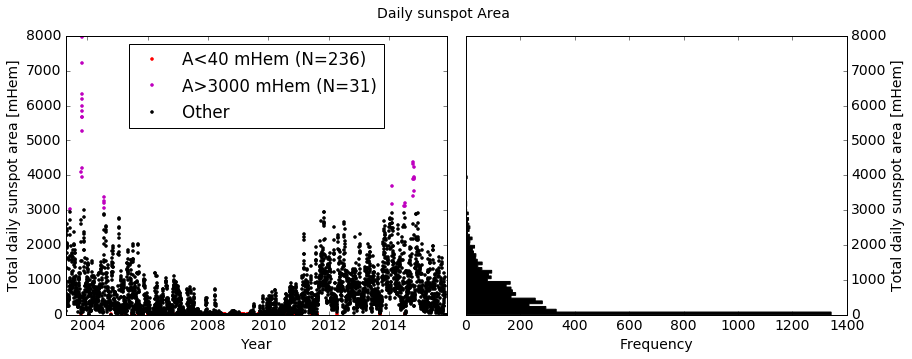

In [285]:
area_table = np.genfromtxt('daily_area.txt', skip_header=1)

area_dates = Time([datetime.datetime(*map(int, area_table[i, 0:3])) 
                   for i in range(len(area_table))])
total_area = area_table[:, 3]
# filter out -1's (empty)
area_dates = area_dates[total_area >= 0]
total_area = total_area[total_area >= 0]
# filter out dates before first SORCE date
first_sorce_date = dates_ap.jd.min()
total_area = total_area[area_dates.jd > first_sorce_date]
area_dates = area_dates[area_dates.jd > first_sorce_date]

spot_upper_limit = 40
spot_lower_limit = 3000
n_bins = 100

indices_few_spots = (0 < total_area) & (total_area < spot_upper_limit)
indices_many_spots = (spot_lower_limit < total_area)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot_date(area_dates[indices_few_spots].plot_date, 
                total_area[indices_few_spots], 'r.', 
                label="A<{0} mHem (N={1})"
                      .format(spot_upper_limit, np.count_nonzero(indices_few_spots)))

ax[0].plot_date(area_dates[indices_many_spots].plot_date, 
                total_area[indices_many_spots], 'm.', 
                label="A>{0} mHem (N={1})"
                      .format(spot_lower_limit, np.count_nonzero(indices_many_spots)))

ax[0].plot_date(area_dates[~indices_few_spots & ~indices_many_spots].plot_date,
                total_area[~indices_few_spots & ~indices_many_spots], 
                'k.', label="Other".format(spot_upper_limit))

ax[0].set(xlabel='Year', ylabel='Total daily sunspot area [mHem]')
ax[0].legend(numpoints=1, loc='upper center')

ax[1].hist(total_area, n_bins, orientation='horizontal',
           histtype='stepfilled', color='k')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].set(xlabel='Frequency', ylabel='Total daily sunspot area [mHem]')
fig.subplots_adjust(wspace=0.05)
fig.suptitle('Daily sunspot Area', fontsize=14)
plt.show()

[(-0.01, 0.05),
 (240.02000000000001, 1500),

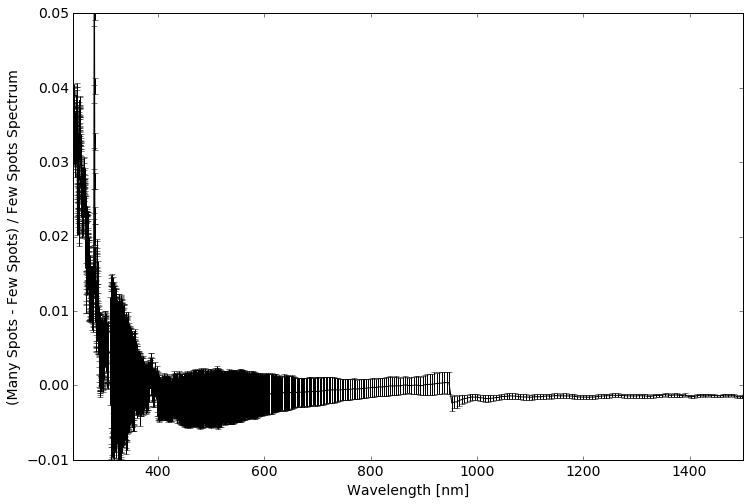

In [286]:
area_few_spots_jds = area_dates[indices_few_spots].jd
nearest_few_spots_jd = np.unique(sorted([np.argmin(np.abs(area_jd - sorce_jds)) 
                                         for area_jd in area_few_spots_jds]))
area_many_spots_jds = area_dates[indices_many_spots].jd
nearest_many_spots_jd = np.unique(sorted([np.argmin(np.abs(area_jd - sorce_jds)) 
                                          for area_jd in area_many_spots_jds]))


sorce_mean_few_spots = np.mean(spectra[nearest_sorce_jd, :, 0], axis=0)
sorce_mean_many_spots = np.mean(spectra[nearest_many_spots_jd, :, 0], axis=0)

sorce_std_few_spots = np.std(spectra[nearest_sorce_jd, :, 0], axis=0)
sorce_std_many_spots = np.std(spectra[nearest_many_spots_jd, :, 0], axis=0)

fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(mean_wavelength, 
            (sorce_mean_many_spots - sorce_mean_few_spots)/sorce_mean_few_spots, 
            np.sqrt(sorce_std_few_spots**2 + sorce_std_many_spots**2),
            color='k', label='Few spots')

ax.set(xlim=(mean_wavelength.min(), 1500),#400),
       ylim=(-0.01, 0.05),
       xlabel='Wavelength [nm]', ylabel='(Many Spots - Few Spots) / Few Spots Spectrum')

### Most different spectra

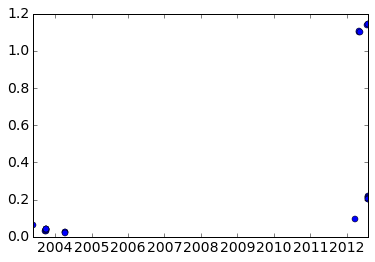

In [287]:
chi2 = np.zeros(len(nearest_many_spots_jd))
for i, spectrum_index in enumerate(nearest_many_spots_jd):
    chi2[i] = np.sum((sorce_mean_few_spots - spectra[spectrum_index, :, 0])**2)
    
plt.plot_date(area_dates[nearest_many_spots_jd].plot_date, chi2);

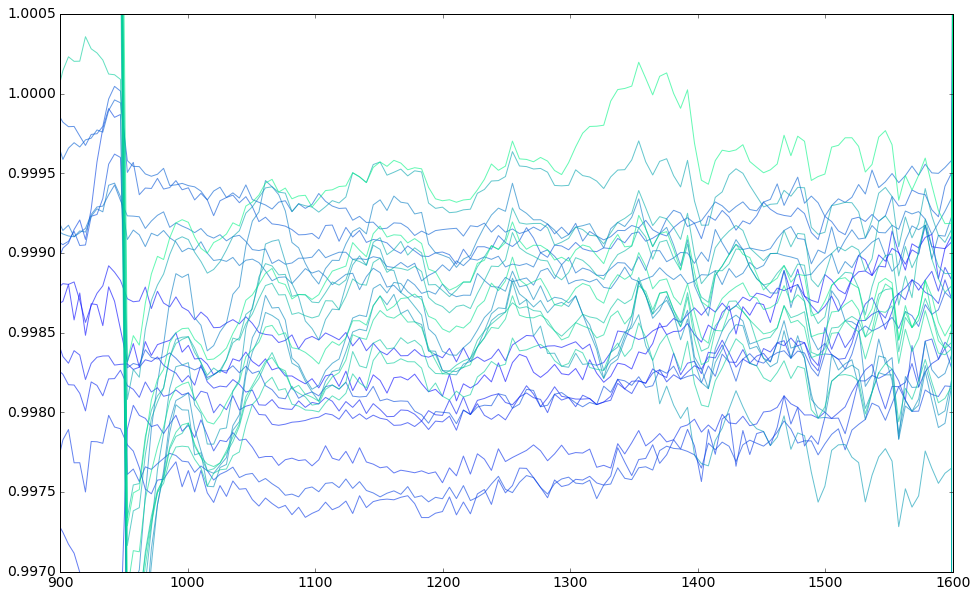

In [301]:

#plt.plot_date(area_dates[nearest_many_spots_jd].plot_date, sorce_mean_few_spots)
plt.figure(figsize=(16, 10))
cmap = plt.cm.winter
for i, spectrum_index in enumerate(nearest_many_spots_jd):
    plt.plot(mean_wavelength, 
             spectra[spectrum_index, :, 0] / sorce_mean_few_spots, 
             '-', color=cmap(float(i)/len(nearest_many_spots_jd)), alpha=0.6)
#plt.ylim([-0.003, 0.0005])
plt.ylim([0.997, 1.0005])
plt.xlim([900, 1600])
plt.show()

In [302]:
!more ref_solar_irradiance_whi-2008_ver2.dat

;
;	Solar Spectral Irradiance Reference Spectra for 
;	Whole Heliosphere Interval (WHI) 2008:
;		Carrington Rotation 2068
;		20 March 2008  to  16 April 2008
;
;	Three periods within WHI are of particular interest:
;	--------------------------------------------------
;		March 25 - March 29 had 3 small active regions on the solar disk
, but TSI is lower.
;				This is considered moderately low solar activity
 and has sunspot blocking (darkening).
;				The 10.7 cm radio flux (F10.7) for this period i
s 83.8
;				The sunspot number (SSN) for this period is 33.4
;				The SORCE TIM Total Solar Irradiance (TSI) is 13
60.696 W/m^2
;
;		March 29 - April 4 had 3 small active regions on the solar disk,
 but TSI is higher.
;				This is considered moderately low solar activity
 and has faculae brightening.
;				The 10.7 cm radio flux (F10.7) for this period i


### Load Solar Irradiance Reference Spectra: 
    
```    
;	Three periods within WHI are of particular interest:
;	--------------------------------------------------
;		March 25 - March 29 had 3 small active regions on the solar disk, but TSI is lower.
;				This is considered moderately low solar activity and has sunspot blocking (darkening).
;				The 10.7 cm radio flux (F10.7) for this period is 83.8
;				The sunspot number (SSN) for this period is 33.4
;				The SORCE TIM Total Solar Irradiance (TSI) is 1360.696 W/m^2
;
;		March 29 - April 4 had 3 small active regions on the solar disk, but TSI is higher.
;				This is considered moderately low solar activity and has faculae brightening.
;				The 10.7 cm radio flux (F10.7) for this period is 77.1
;				The sunspot number (SSN) for this period is 16.2
;				The SORCE TIM Total Solar Irradiance (TSI) is 1360.944 W/m^2
;
;		April 10-16 was the Quiet Sun (QS) campaign (which did turn out quiet)
;				This is considered to very close to solar cycle minimum condition.
;				The 10.7 cm radio flux (F10.7) for this period is 68.9
;				The sunspot number (SSN) for this period is 2.0
;				The SORCE TIM Total Solar Irradiance (TSI) is 1360.840 W/m^2


;	Data Columns:
; 	-------------
;		0    Wavelength (nm) -  0.1-nm intervals on 0.05-nm centers
;		1    Irradiance (W/m^2/nm) for March 25 - March 29 (5-day average)
;		2    Irradiance (W/m^2/nm) for March 30 - April 4 (6-day average)
;		3    Irradiance (W/m^2/nm) for April 10 - April 16 (7-day average)
;		4	 Data Source:  1 = TIMED XPS, 2 = Rocket EVE, 3 = TIMED EGS, 
;						4 = SORCE SOLSTICE, 5 = SORCE SIM 
;						-1 for data source means the bin has been filled (not measured)
;		5    Accuracy / Uncertainty (BLANK in this version)
```

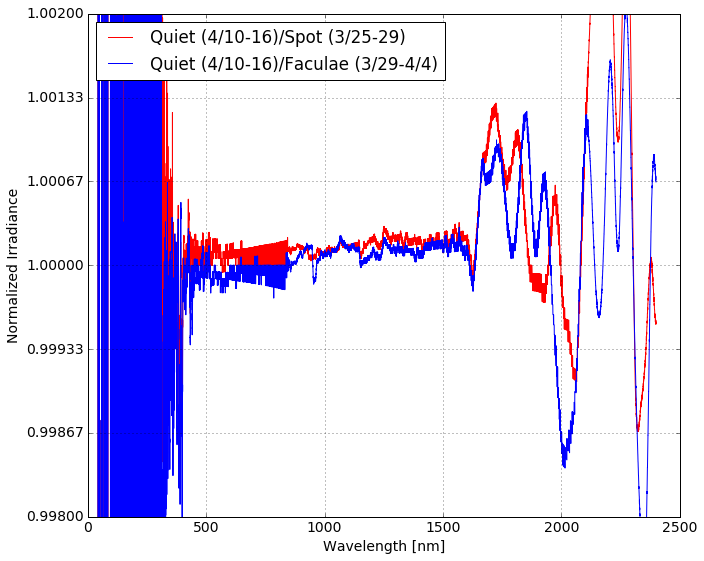

In [341]:
whi_sirs = np.genfromtxt('ref_solar_irradiance_whi-2008_ver2.dat', skip_header=142)
sirs_wavelengths = whi_sirs[:, 0]
sirs_quiet = whi_sirs[:, 3]
sirs_spot = whi_sirs[:, 1]
sirs_fac = whi_sirs[:, 2]

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# ax[0].semilogy(sirs_wavelengths, sirs_quiet, color='k', label='Quiet')
# ax[0].semilogy(sirs_wavelengths, sirs_spot, color='r', label='Spot')
# ax[0].semilogy(sirs_wavelengths, sirs_fac, color='b', label='Faculae')
# ax[0].set(ylim=(1e-7, 10))

# ax[0].plot(sirs_wavelengths, sirs_spot - sirs_quiet, color='r', label='Spot - Quiet')
# ax[0].plot(sirs_wavelengths, sirs_fac - sirs_quiet, color='b', label='Faculae - Quiet')
# ax[0].set(ylim=(-5e-4, 5e-4))

ax.plot(sirs_wavelengths, sirs_quiet/sirs_spot, color='r', label='Quiet (4/10-16)/Spot (3/25-29)')
ax.plot(sirs_wavelengths, sirs_quiet/sirs_fac, color='b', label='Quiet (4/10-16)/Faculae (3/29-4/4)')
y_lims = (1-2e-3, 1+2e-3)
y_ticks = np.linspace(y_lims[0], y_lims[1], 7)
y_labels = ["{0:0.5f}".format(y) for y in y_ticks]
ax.set(xlabel='Wavelength [nm]', ylabel='Normalized Irradiance', ylim=y_lims)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.legend(loc='upper left')
ax.grid()
fig.tight_layout()
fig.savefig('normalized_sirs.png', bbox_inches='tight')
plt.show()

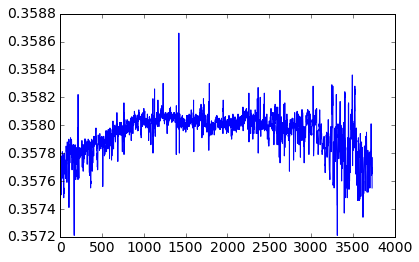

In [349]:
#np.corrcoef

wavelength_index_near_Mg = np.argmin(np.abs(mean_wavelength - 280))
wavelength_index_test = np.argmin(np.abs(mean_wavelength - 1400))

#plt.plot(spectra[:, wavelength_index_near_Mg, 0])
plt.plot(spectra[:, wavelength_index_test, 0])
plt.show()

### Searching for correlations

Does star spot area correlate with any bandpass? 

In [ ]:
def interpolated_area(test_date):
    return np.interp(test_date, area_dates.jd, total_area)
interpolated_area = interpolated_area(sorce_jds)


correlations = np.zeros(len(mean_wavelength))
for i, wave in enumerate(mean_wavelength):
    correlations[i] = np.corrcoef(interpolated_area, spectra[:, i, 0])[0, 1]

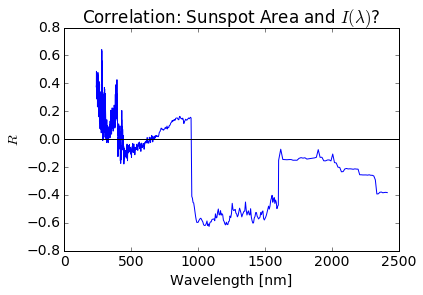

In [369]:
fig, ax = plt.subplots()
ax.plot(mean_wavelength, correlations)
ax.axhline(0, color='k')
ax.set(xlabel='Wavelength [nm]', ylabel='$R$', 
       title='Correlation: Sunspot Area and $I(\lambda)$?');